In [45]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from numpy import linalg
import cvxopt
import cvxopt.solvers
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

data = pd.read_csv("data.csv", header = None)
data.head()

X = np.array(data.loc[:, 0:5]).astype('double')
y = np.array(data.loc[:, 6])

y = np.where(y == 0, -1, y).astype('double')

X = (X - X.mean())/X.std()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)
print(X_train.shape)

(571, 6)


In [46]:
C = [0.5, 1, 5, 10, 15, 20]

for k in ['linear', 'rbf']:
    print("Kernel: ", k)
    for c in C:
        clf = SVC(kernel='linear', C=c)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print("C = ", c)
        print("Accuracy: ", accuracy_score(y_pred, y_test))
    print('\n')

Kernel:  linear
C =  0.5
Accuracy:  0.6503496503496503
C =  1
Accuracy:  0.6573426573426573
C =  5
Accuracy:  0.7202797202797203
C =  10
Accuracy:  0.7412587412587412
C =  15
Accuracy:  0.7482517482517482
C =  20
Accuracy:  0.7342657342657343


Kernel:  rbf
C =  0.5
Accuracy:  0.6503496503496503
C =  1
Accuracy:  0.6573426573426573
C =  5
Accuracy:  0.7202797202797203
C =  10
Accuracy:  0.7412587412587412
C =  15
Accuracy:  0.7482517482517482
C =  20
Accuracy:  0.7342657342657343




In [47]:
def linear_kernel(x, y):
    return np.dot(x, y)

def gaussian_kernel(x, y, sigma=0.8):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

class SVM(object):

    def __init__(self, kernel=linear_kernel, C=1, sigma=0.8):
        self.kernel = kernel
        self.sigma = sigma
        self.C = C

    def fit(self, X, y):
        n_samples, n_features = X.shape

        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])
        
        
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)


        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagranzovi multiplikatori
        a = np.array(solution['x']).flatten()

        # Odbacujemo sve dovoljno male Lagranzove multiplikatore. Vektori koji njima odgovaraju ne ucestvuju u formiranju 
        # hiperravni
        sv_indxs = a > 1e-4
        ind = np.arange(len(a))[sv_indxs]
        self.a = a[sv_indxs]
        self.sv = X[sv_indxs]
        self.sv_y = y[sv_indxs]
        
        print("Broj nosecih vektora je: " + str(len(self.sv)))

        # Odredjivanje bias-a
        self.b = 0
        for n in range(len(self.a)):
            self.b += (self.sv_y[n] - np.sum(self.a * self.sv_y * K[ind[n], sv_indxs]))
        self.b /= len(self.sv)

        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def predict(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for n in range(len(self.a)):
                    s += self.a[n] * self.sv_y[n] * self.kernel(X[i], self.sv[n], self.sigma)
                y_predict[i] = s
                
            return np.sign(y_predict + self.b)

In [48]:
C = [0.1, 1, 5, 10, 20, 30, 40, 50, 60, 80, 100, 500, 1000, 1500, 2000, 3500, 5000]

accuracy = np.zeros(len(C))

for i in range(len(C)):
    model = SVM(kernel=linear_kernel, C=C[i])
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    accuracy[i] = accuracy_score(y_pred.astype(int), y_test.astype(int))
    
    print("C = ", C[i])
    print("Accuracy: ", accuracy[i])
    print('\n')

     pcost       dcost       gap    pres   dres
 0: -2.6231e+02 -1.4105e+02  4e+03  3e+01  3e-14
 1: -5.0443e+01 -1.3205e+02  3e+02  2e+00  3e-14
 2: -3.6228e+01 -9.8202e+01  9e+01  2e-01  6e-15
 3: -3.8036e+01 -4.7524e+01  1e+01  2e-02  2e-15
 4: -4.0028e+01 -4.3245e+01  3e+00  6e-03  3e-15
 5: -4.0555e+01 -4.2409e+01  2e+00  3e-03  2e-15
 6: -4.0862e+01 -4.1996e+01  1e+00  1e-03  2e-15
 7: -4.1081e+01 -4.1690e+01  6e-01  7e-04  3e-15
 8: -4.1213e+01 -4.1515e+01  3e-01  3e-04  3e-15
 9: -4.1296e+01 -4.1408e+01  1e-01  1e-04  3e-15
10: -4.1321e+01 -4.1378e+01  6e-02  3e-05  2e-15
11: -4.1341e+01 -4.1354e+01  1e-02  6e-06  2e-15
12: -4.1346e+01 -4.1349e+01  3e-03  6e-07  3e-15
13: -4.1347e+01 -4.1347e+01  4e-04  8e-08  3e-15
14: -4.1347e+01 -4.1347e+01  2e-05  8e-10  3e-15
Optimal solution found.
Broj nosecih vektora je: 417
C =  0.1
Accuracy:  0.02097902097902098


     pcost       dcost       gap    pres   dres
 0: -4.6912e+02 -1.5835e+03  6e+03  3e+00  6e-14
 1: -3.4279e+02 -1.2082e+

     pcost       dcost       gap    pres   dres
 0:  9.6633e+05 -1.2602e+08  2e+08  6e-01  1e-11
 1:  8.4594e+05 -3.4570e+07  4e+07  2e-12  1e-11
 2:  4.8307e+05 -5.2854e+06  6e+06  9e-13  8e-12
 3:  2.6034e+05 -4.3539e+06  5e+06  5e-13  9e-12
 4: -6.5249e+03 -1.0905e+06  1e+06  4e-12  8e-12
 5: -7.2719e+04 -6.2981e+05  6e+05  5e-13  1e-11
 6: -9.7638e+04 -2.1906e+05  1e+05  9e-13  1e-11
 7: -1.0980e+05 -1.8387e+05  7e+04  2e-16  1e-11
 8: -1.1322e+05 -1.6765e+05  5e+04  9e-13  1e-11
 9: -1.1630e+05 -1.5182e+05  4e+04  5e-12  1e-11
10: -1.1817e+05 -1.3363e+05  2e+04  5e-12  2e-11
11: -1.2029e+05 -1.2157e+05  1e+03  2e-12  2e-11
12: -1.2044e+05 -1.2045e+05  1e+01  2e-12  1e-11
13: -1.2044e+05 -1.2044e+05  1e-01  3e-12  1e-11
14: -1.2044e+05 -1.2044e+05  1e-03  7e-12  1e-11
Optimal solution found.
Broj nosecih vektora je: 571
C =  500
Accuracy:  0.27972027972027974


     pcost       dcost       gap    pres   dres
 0:  4.1006e+06 -5.0299e+08  1e+09  6e-01  3e-11
 1:  3.6133e+06 -1.3736e+

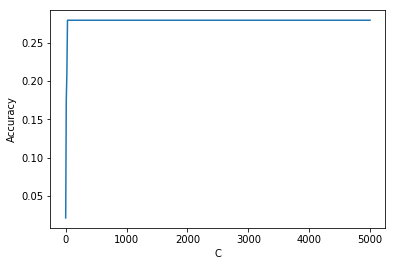

In [27]:
plt.plot(C, accuracy)
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.show()

In [34]:
#sigma = [0.2, 0.8, 1.6, 3.5, 7.5]
sigma = [0.8]
C = [0.1, 1, 10, 100, 500, 1000, 2000, 5000, 7500, 10000, 15000, 20000]

accuracy = np.zeros((len(sigma), len(C)))
for s in range(len(sigma)):
    for i in range(len(C)):
        model = SVM(kernel=gaussian_kernel, C=C[i], sigma=sigma[s])

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        print(type(y_test[0]))

        accuracy[s, i] = accuracy_score(y_pred.astype(int), y_test.astype(int))
        
        print("sigma = " + str(sigma[s]))
        print("C = " + str(C[i]))
        print("Tacnost = " + str(accuracy[s, i]))
        print('\n')
    
print(accuracy)

     pcost       dcost       gap    pres   dres
 0: -2.4208e+02 -1.3625e+02  4e+03  3e+01  3e-15
 1: -4.0277e+01 -1.2730e+02  2e+02  5e-01  3e-15
 2: -3.7261e+01 -5.3232e+01  2e+01  6e-16  1e-15
 3: -4.0257e+01 -4.2904e+01  3e+00  6e-16  1e-15
 4: -4.0738e+01 -4.2041e+01  1e+00  2e-16  6e-16
 5: -4.0892e+01 -4.1797e+01  9e-01  2e-16  6e-16
 6: -4.1040e+01 -4.1559e+01  5e-01  1e-15  6e-16
 7: -4.1180e+01 -4.1342e+01  2e-01  9e-16  8e-16
 8: -4.1223e+01 -4.1285e+01  6e-02  7e-16  8e-16
 9: -4.1243e+01 -4.1260e+01  2e-02  2e-16  8e-16
10: -4.1249e+01 -4.1253e+01  4e-03  2e-16  8e-16
11: -4.1251e+01 -4.1252e+01  1e-03  7e-16  8e-16
12: -4.1251e+01 -4.1251e+01  8e-05  9e-16  9e-16
13: -4.1251e+01 -4.1251e+01  2e-06  7e-16  1e-15
Optimal solution found.
Broj nosecih vektora je: 439
<class 'numpy.float64'>
sigma = 0.8
C = 0.1
Tacnost = 0.6993006993006993


     pcost       dcost       gap    pres   dres
 0: -4.3076e+02 -1.4491e+03  5e+03  2e+00  5e-15
 1: -3.0529e+02 -9.7227e+02  7e+02  2e-02

16: -1.1167e+06 -1.1167e+06  2e+00  7e-11  2e-11
17: -1.1167e+06 -1.1167e+06  2e-01  7e-11  2e-11
Optimal solution found.
Broj nosecih vektora je: 465
<class 'numpy.float64'>
sigma = 0.8
C = 7500
Tacnost = 0.8111888111888111


     pcost       dcost       gap    pres   dres
 0:  5.1887e+08 -2.0645e+10  2e+10  3e-11  3e-11
 1:  2.3267e+08 -2.0265e+09  2e+09  3e-11  2e-11
 2:  4.9275e+07 -3.8434e+08  4e+08  2e-11  2e-11
 3:  8.7808e+06 -8.5963e+07  9e+07  2e-16  2e-11
 4:  1.2670e+06 -3.7946e+07  4e+07  3e-11  2e-11
 5: -3.7482e+05 -8.2127e+06  8e+06  3e-11  2e-11
 6: -1.0295e+06 -3.3146e+06  2e+06  2e-16  2e-11
 7: -1.2709e+06 -2.0339e+06  8e+05  2e-11  2e-11
 8: -1.3546e+06 -1.7751e+06  4e+05  4e-11  2e-11
 9: -1.3999e+06 -1.6247e+06  2e+05  7e-11  2e-11
10: -1.4309e+06 -1.5245e+06  9e+04  3e-11  2e-11
11: -1.4461e+06 -1.4807e+06  3e+04  1e-10  3e-11
12: -1.4532e+06 -1.4654e+06  1e+04  6e-11  3e-11
13: -1.4558e+06 -1.4600e+06  4e+03  8e-11  3e-11
14: -1.4568e+06 -1.4582e+06  1e+03  4e-

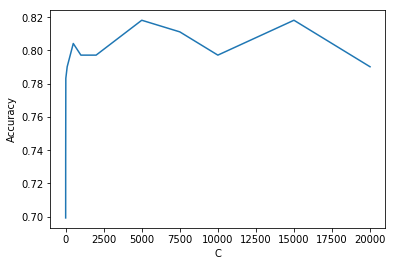

In [35]:
plt.plot(C, accuracy[0])
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.show()

     pcost       dcost       gap    pres   dres
 0:  1.2918e+08 -5.1632e+09  5e+09  4e-12  1e-11
 1:  5.7672e+07 -5.0678e+08  6e+08  1e-11  1e-11
 2:  1.1920e+07 -9.6043e+07  1e+08  4e-11  1e-11
 3:  1.8242e+06 -2.1369e+07  2e+07  7e-12  9e-12
 4: -1.2698e+04 -9.4870e+06  9e+06  2e-11  8e-12
 5: -4.1256e+05 -2.6082e+06  2e+06  3e-11  8e-12
 6: -6.2965e+05 -1.3230e+06  7e+05  7e-12  1e-11
 7: -6.9332e+05 -1.0459e+06  4e+05  5e-11  1e-11
 8: -7.2432e+05 -9.1376e+05  2e+05  9e-12  1e-11
 9: -7.4320e+05 -8.3905e+05  1e+05  1e-11  1e-11
10: -7.5677e+05 -7.9102e+05  3e+04  5e-11  1e-11
11: -7.5961e+05 -7.8363e+05  2e+04  1e-11  1e-11
12: -7.6398e+05 -7.7312e+05  9e+03  3e-11  1e-11
13: -7.6613e+05 -7.6853e+05  2e+03  3e-11  1e-11
14: -7.6688e+05 -7.6709e+05  2e+02  3e-11  1e-11
15: -7.6695e+05 -7.6696e+05  1e+01  3e-11  1e-11
16: -7.6696e+05 -7.6696e+05  2e-01  2e-11  1e-11
Optimal solution found.
Broj nosecih vektora je: 472
Accuracy:  0.8181818181818182
[[67 11]
 [15 50]]
              pre

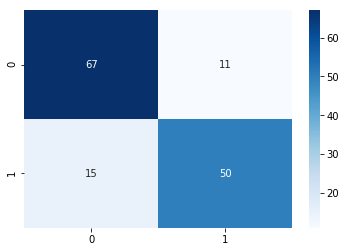

In [40]:
import seaborn

model = SVM(kernel=gaussian_kernel, C=5000, sigma=0.8)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy: ", accuracy_score(y_pred, y_test))

print(confusion_matrix(y_test, y_pred))
seaborn.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

print(classification_report(y_test, y_pred))